# Getting Started with Pyro

Okay!  So we've gotten our feet wet with torch, and actually feel pretty good.  It was quite easy to implement a very readable version of gradient descent, which I was quite happy with. 

With that groundwork, lets explore pyro!  Pyro was developed by Uber for Bayesian inference, and looks like a good candidate as a next step from pymc3.

As we're going through it's important to keep a few things in mind:

  *  This isn't our only option. We could still transition over to Tensorflow and Edward.
  *  We want readible models in the same way that pymc3 is very transparent about its models.  
  *  A model in pyro shouldn't be much longer that its corresponding version in pymc3.

And let's get started!

In [1]:
import torch as t # I don't see the `as t` thing in other code, but I like it
from torch.autograd import Variable

import pyro
import pyro.distributions as dist

In [2]:
# Let create the unit normal!
mu = Variable(t.zeros(1))
sigma = Variable(t.ones(1))
# dist.normal returns a sample
X = dist.normal(mu, sigma)

In [3]:
# Here's our sample
print(X)

Variable containing:
-0.3581
[torch.FloatTensor of size 1]



In [4]:
# and it's corresponding log probability
-dist.normal.log_pdf(X, mu, sigma)

Variable containing:
 0.9831
[torch.FloatTensor of size 1]

In pyro it seems like we'll often be mroe likely to describe getting a sample in a different way.

In [5]:
# Sample with the pyro.sample function
Y = pyro.sample("unit_norm", dist.normal, mu, sigma)

In [6]:
Y

Variable containing:
-0.2223
[torch.FloatTensor of size 1]

Let's put this together into a model

In [56]:
def weather():
    """The weather generator function
    
    A stochastic function which returns a sample
    with either a cloudy or sunny classification
    and the temperature
    """
    # Cloud happens with probability 0.3
    cloudy = pyro.sample('cloudy', dist.bernoulli,
                         Variable(t.Tensor([0.3])))
    
    # If the value of the cloudy sample is 1, then cloudy
    # I love how this is done with python control flow
    if cloudy.data[0] == 1.0:
        cloudy = 'cloudy'
    else:
        cloudy = 'sunny'
        
    # Once we know the weather, sample the temperature
    # These provide our priors for cloud and sunny weather
    # The use of dictionaries is just some nice syntax that's
    # saving us from writing a longer if statement.
    mean_temp = {'cloudy': [55.], 'sunny': [75.]}[cloudy]
    sigma_temp = {'cloudy': [10.], 'sunny': [15.]}[cloudy]
    temp = pyro.sample('temp', dist.normal,
                       Variable(t.Tensor(mean_temp)),
                       Variable(t.Tensor(sigma_temp)))
    return cloudy, temp.data[0]

In [57]:
# Drawing some samples from our generator
for _ in range(3):
    print(weather())

('sunny', 50.01393127441406)
('sunny', 82.3631362915039)
('cloudy', 50.26835250854492)


In [60]:
# Building on an existing stochastic function is easy, since it's
# all just python
def go_to_the_beach():
    cloudy, temp = weather()
    if temp > 80.:
        p = 0.7
    elif temp < 80. and cloudy == 'sunny':
        p = 0.4
    else:
        p = 0.05
    
    decision = pyro.sample('decision', dist.bernoulli,
                           Variable(t.Tensor([p])))
    
    outcome = 'yes' if decision.data[0] == 1 else 'no'
    return cloudy, temp, outcome

In [65]:
for _ in range(3):
    print(go_to_the_beach())

('sunny', 88.06019592285156, 'yes')
('cloudy', 59.7537841796875, 'no')
('sunny', 65.88948822021484, 'yes')


Delightful!  Creating different random variables and then sampling from them is quite straightforward. Maybe even easier than pymc3.

So lets move on and get to some inference. 

Suppose we have a math assessment we give to kids (funny right), but it doesn't always give the best score representing a students ability.  To compensate we will add a 90% confidence interval based on our observations of the student. 

In [7]:
def math_assessment(low, high):
    # Compute the parameters of the distribution corresponding  
    # to my CI
    mu = Variable(t.Tensor([(low + high) / 2.]))
    sigma = Variable(t.Tensor([(high - low) / 3.29]))
    quantile = pyro.sample("quantile", dist.normal, mu, sigma)
    # Our CI serves as the mean for our measurement data
    # Note that this measurement is an observed variable, but we
    # haven't indicated that within the model quite yet.  We could
    # do so by adding the obs argument and providing the observed
    # 
    return pyro.sample("measurement", dist.normal, quantile, Variable(t.Tensor([50.])))

In [8]:
for _ in range(3):
    print(math_assessment(150, 250))

Variable containing:
 147.9533
[torch.FloatTensor of size 1]

Variable containing:
 167.4789
[torch.FloatTensor of size 1]

Variable containing:
 181.2075
[torch.FloatTensor of size 1]



In [9]:
from pyro.infer import Marginal, Importance
# This class is an importance sampler which we'll use to draw
# from the posterior of math_assessment. It looks like we'll often
# just pass this class into Marginal. 
posterior = Importance(math_assessment, num_samples=100)

In [10]:
guess = (150, 250)
# We'll now define marginal.  Marginal acts exactly like math_assessment
# except 
marginal = Marginal(posterior)
print(marginal(*guess))

Variable containing:
 202.7524
[torch.FloatTensor of size 1]



Text(0,0.5,'#')

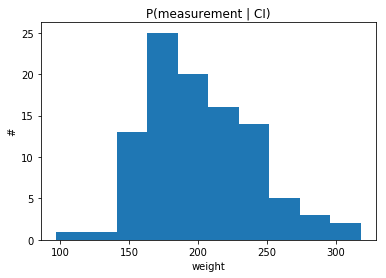

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([marginal(150, 250).data[0] for _ in range(100)])
plt.title("P(measurement | CI)")
plt.xlabel("weight")
plt.ylabel("#")

# Bayesian Linear Regression

In the pytorch getting started we concluded with a basic demo of gradient descent for linear regression.  We'll do the same thing here, but this time for Bayesian Linear Regression.  After building the model, we'll reflect on how it compres to pymc3.

We're following the guide available [on pyro's website.](http://pyro.ai/examples/bayesian_regression.html)

In [16]:
# Just to make sure we have everything we need
import numpy as np
import torch
import torch.nn as nn

from torch.autograd import Variable

import pyro
from pyro.distributions import Normal
from pyro.infer import SVI
from pyro.optim import Adam

In [48]:
N = 1000  # size of toy data
p = 1    # number of features

def build_linear_dataset(N, noise_std=0.1):
    # Construct the data set in numpy
    X = np.linspace(-5, 5, num=N)
    y = 3 * X + 1 + np.random.normal(0, noise_std, size=N)
    X, y = X.reshape((N, 1)), y.reshape((N, 1))
    # Then stuff them in pytorch variables
    X, y = Variable(torch.Tensor(X)), Variable(torch.Tensor(y))
    return torch.cat((X, y), 1)

### Starting with the deterministic model

Curiously we start with a deterministic model and then consider distributions over its parameters. 

In [49]:
class LinearRegression(nn.Module):
    """Linear Regression in pytorch"""
    def __init__(self, p):
        # Run nn.Module.__init__()
        super(LinearRegression, self).__init__()
        # Short hand for our linear module
        self.linear = nn.Linear(p, 1)
        
    def forward(self, x):
        """A typical pattern for nets is to define the forward path"""
        # But this one's a little anti-climactic
        return self.linear(x)

In [50]:
regression_model = LinearRegression(p)

In [58]:
# Setting up our loss function and optimizer and
# storing them in expressive names. 
loss_fn = torch.nn.MSELoss(size_average=False)
optim = torch.optim.Adam(regression_model.parameters(), lr=0.01)
num_iterations = 500

def main():
    data = build_linear_dataset(N, p)
    x_data = data[:, :-1]
    y_data = data[:, -1]
    for j in range(num_iterations):
        # run the model forward on the data
        y_pred = regression_model(x_data)
        # calculate the mse loss
        loss = loss_fn(y_pred, y_data)
        # initialize gradients to zero
        optim.zero_grad()
        # backpropagate
        loss.backward()
        # take a gradient step
        optim.step()
        if (j + 1) % 50 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss.data[0]))
    # Inspect learned parameters
    print("Learned parameters:")
    for name, param in regression_model.named_parameters():
        print("%s: %.3f" % (name, param.data.numpy()))

In [65]:
main()

[iteration 0050] loss: 1033.7458
[iteration 0100] loss: 1033.7352
[iteration 0150] loss: 1033.7360
[iteration 0200] loss: 1033.7356
[iteration 0250] loss: 1033.7357
[iteration 0300] loss: 1033.7357
[iteration 0350] loss: 1033.7356
[iteration 0400] loss: 1033.7357
[iteration 0450] loss: 1033.7357
[iteration 0500] loss: 1033.7357
Learned parameters:
linear.weight: 3.004
linear.bias: 0.946


Now that we have a linear regression model, lets make it Bayesian

In [ ]:
mu = Varia